<center><h1>DSCI-552 HOMEWORK 4</h1>
<br>
<font size="3">Name: Vorapoom Thirapatarapong</font>
<br>
<font size="3">USC ID: 4397330150 Github Username: bvorapoom</font></center>

#### import packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import math
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFE
from sklearn.metrics import (confusion_matrix, plot_roc_curve, roc_auc_score, multilabel_confusion_matrix, auc, roc_curve)
from sklearn.naive_bayes import (GaussianNB, MultinomialNB)
from imblearn.under_sampling import RandomUnderSampler 

#### get the dataset

In [2]:
# create dataframe to store main train/test data
df_main_test = pd.DataFrame(columns = ['activities', 'dataset_number', 'df'], dtype = object)
df_main_train = pd.DataFrame(columns = ['activities', 'dataset_number', 'df'], dtype = object)

# define indices of file path
csv_index_test = {
    'bending1': np.arange(1, 3, 1),
    'bending2': np.arange(1, 3, 1),
    'cycling': np.arange(1, 4, 1),
    'lying': np.arange(1, 4, 1),
    'sitting': np.arange(1, 4, 1),
    'standing': np.arange(1, 4, 1),
    'walking': np.arange(1, 4, 1)
}
csv_index_train = {
    'bending1': np.arange(3, 8, 1),
    'bending2': np.arange(3, 7, 1),
    'cycling': np.arange(4, 16, 1),
    'lying': np.arange(4, 16, 1),
    'sitting': np.arange(4, 16, 1),
    'standing': np.arange(4, 16, 1),
    'walking': np.arange(4, 16, 1)
}

In [3]:
# loading test dataset
for acti, ds_list in csv_index_test.items():
    for ds_no in ds_list:
        csv_path = '../data/ARem/' + acti + '/dataset' + str(ds_no) + '.csv'
        temp_df = pd.read_csv(csv_path, skiprows = 4)
        temp_df.columns = ['time' if col == '# Columns: time' else col for col in temp_df.columns]
        temp_df.set_index('time', inplace = True)
        df_main_test.loc[len(df_main_test), :] = [acti, ds_no, temp_df]
        
# loading train dataset
for acti, ds_list in csv_index_train.items():
    for ds_no in ds_list:
        csv_path = '../data/ARem/' + acti + '/dataset' + str(ds_no) + '.csv'
        temp_df = pd.read_csv(csv_path, skiprows = 4)
        temp_df.columns = ['time' if col == '# Columns: time' else col for col in temp_df.columns]
        temp_df.set_index('time', inplace = True)
        df_main_train.loc[len(df_main_train), :] = [acti, ds_no, temp_df]

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/internals/blocks.py:993: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.array(value)


#### create functions

In [4]:
# split dataframe's rows to columns
def split_df_rows_to_columns(df, no_splits, target_col = 'activities'):
    split_size = math.ceil(len(df) / no_splits)
    split_df = pd.concat([df.iloc[i * split_size:(i + 1) * split_size, :].reset_index(drop = True) for i in range(no_splits)], axis = 1)
    split_df.columns = ['f' + str(num) for num in range(1, no_splits * len(df.columns) + 1)]
    return split_df


# generate time-domain features from time-series data
def gen_time_domain_features(df_main, 
                             operation_list = ['min', 'max', 'mean', 'median', 'sd', '1stquart', '3rdquart'], 
                             target_cols_ind = range(6),
                             split = 1):
    
    col_list = ['f' + str(no_feature) + '_' + str(op) for no_feature in range(1, len(target_cols_ind) * split + 1) for op in operation_list] + ['activities']
    df_timedomain_features = pd.DataFrame(columns = col_list, dtype = float)
    
    all_op = ['min', 'max', 'mean', 'median', 'sd', '1stquart', '3rdquart']
    
    for ind, instance in df_main.iterrows():
        
        temp_list = []
        instance_df = instance['df'].iloc[:, target_cols_ind]
        instance_df_split = split_df_rows_to_columns(instance_df, split)
        
        for col in instance_df_split.columns:
            target_df = instance_df_split.loc[:, col]
            temp_min = target_df.min()
            temp_max = target_df.max()
            temp_mean = target_df.mean()
            temp_median = target_df.quantile([0.5]).values[0]
            temp_sd =  target_df.std()
            temp_1stquart = target_df.quantile([0.25]).values[0]
            temp_3rdquart = target_df.quantile([0.75]).values[0]
            temp_all_vals = [temp_min, temp_max, temp_mean, temp_median, temp_sd, temp_1stquart, temp_3rdquart]
            selected_op_ind = [all_op.index(i) for i in all_op if i in operation_list]
            temp_selected_vals = [temp_all_vals[i] for i in selected_op_ind]
            temp_list.extend(temp_selected_vals)
            
        df_timedomain_features.loc[len(df_timedomain_features), :] = temp_list + [instance['activities']]
    
    return df_timedomain_features


# multiclass ROC function referred from https://scikit-learn.org/0.15/auto_examples/plot_roc.html and https://stackoverflow.com/questions/45332410/roc-for-multiclass-classification
def plot_multiclass_roc(cls, X, y, n_classes, figsize = (17, 6)):
    y_score = cls.decision_function(X)

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # binarize the output
    y_dummies = pd.get_dummies(y, drop_first = False).values
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_dummies[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # roc for each class
    fig, ax = plt.subplots(figsize = figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC Curves for Multiclass Classification')
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for label %i' % (roc_auc[i], i))
    ax.legend(loc = "best")
    ax.grid(alpha = 0.4)
    sns.despine()
    plt.show()




# Time Series Classification Part 2: Binary and Multiclass Classification

## (a) Binary Classification Using Logistic Regression

#### (a)-i. Assume that you want to use the training set to classify bending from other activities, i.e. you have a binary classification problem. Depict scatter plots of the features you specified in 1(c)iv extracted from time series 1, 2, and 6 of each instance, and use color to distinguish bending vs. other activities. (See p. 129 of the textbook)

In [5]:
# create time domain features (mean, median, std) using time series 1, 2, and 6 
df_bending_no_split = gen_time_domain_features(df_main_train, operation_list = ['mean', 'median', 'sd'], 
                             target_cols_ind = [0, 1, 5], split = 1)

# remap activies to bending and other activities
df_bending_no_split.loc[(df_bending_no_split['activities'].str.startswith('bending')), 'activities'] = 'bending'
df_bending_no_split.loc[~(df_bending_no_split['activities'].str.startswith('bending')), 'activities'] = 'other_activities'

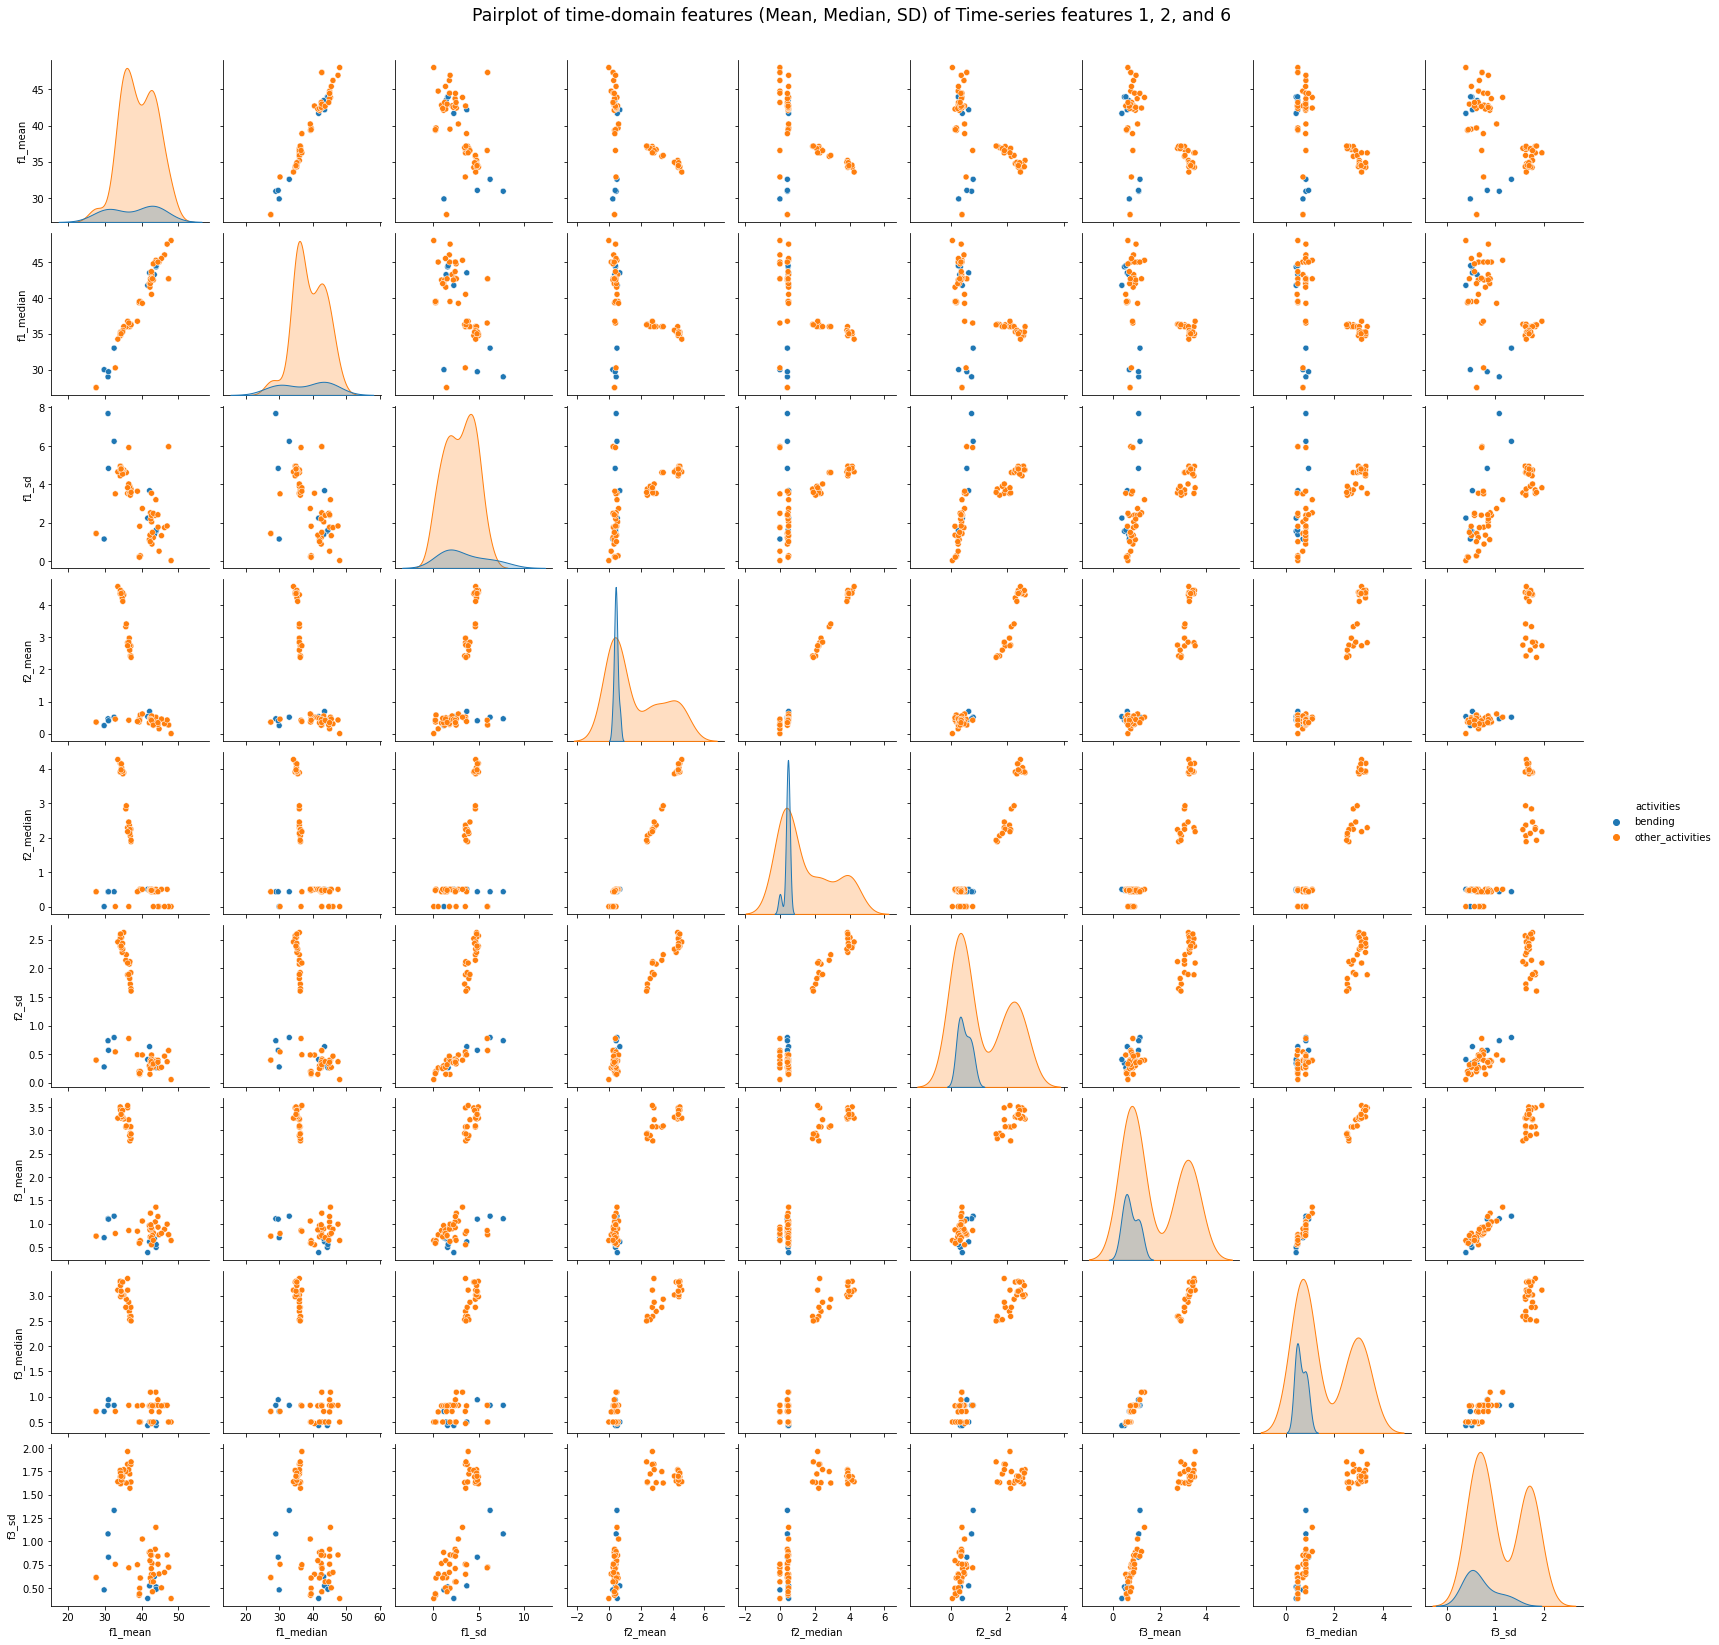

In [6]:
# scatter plot of selected time-domain features
sns.pairplot(data = df_bending_no_split, hue = 'activities')
plt.suptitle('Pairplot of time-domain features (Mean, Median, SD) of Time-series features 1, 2, and 6', fontsize = 'xx-large', y = 1.02)
plt.show()

#### (a)-ii. Break each time series in your training set into two (approximately) equal length time series. Now instead of 6 time series for each of the training instances, you have 12 time series for each training instance. Repeat the experiment in 2(a)i, i.e depict scatter plots of the features extracted from both parts of the time series 1,2, and 6. Do you see any considerable difference in the results with those of 2(a)i?

In [7]:
# split time series to 2: create time domain features (mean, median, std) using time series 1, 2, and 6
df_bending_split_2 = gen_time_domain_features(df_main_train, operation_list = ['mean', 'median', 'sd'], 
                             target_cols_ind = [0, 1, 5], split = 2)

# remap activies to bending and other activities
df_bending_split_2.loc[(df_bending_split_2['activities'].str.startswith('bending')), 'activities'] = 'bending'
df_bending_split_2.loc[~(df_bending_split_2['activities'].str.startswith('bending')), 'activities'] = 'other_activities'

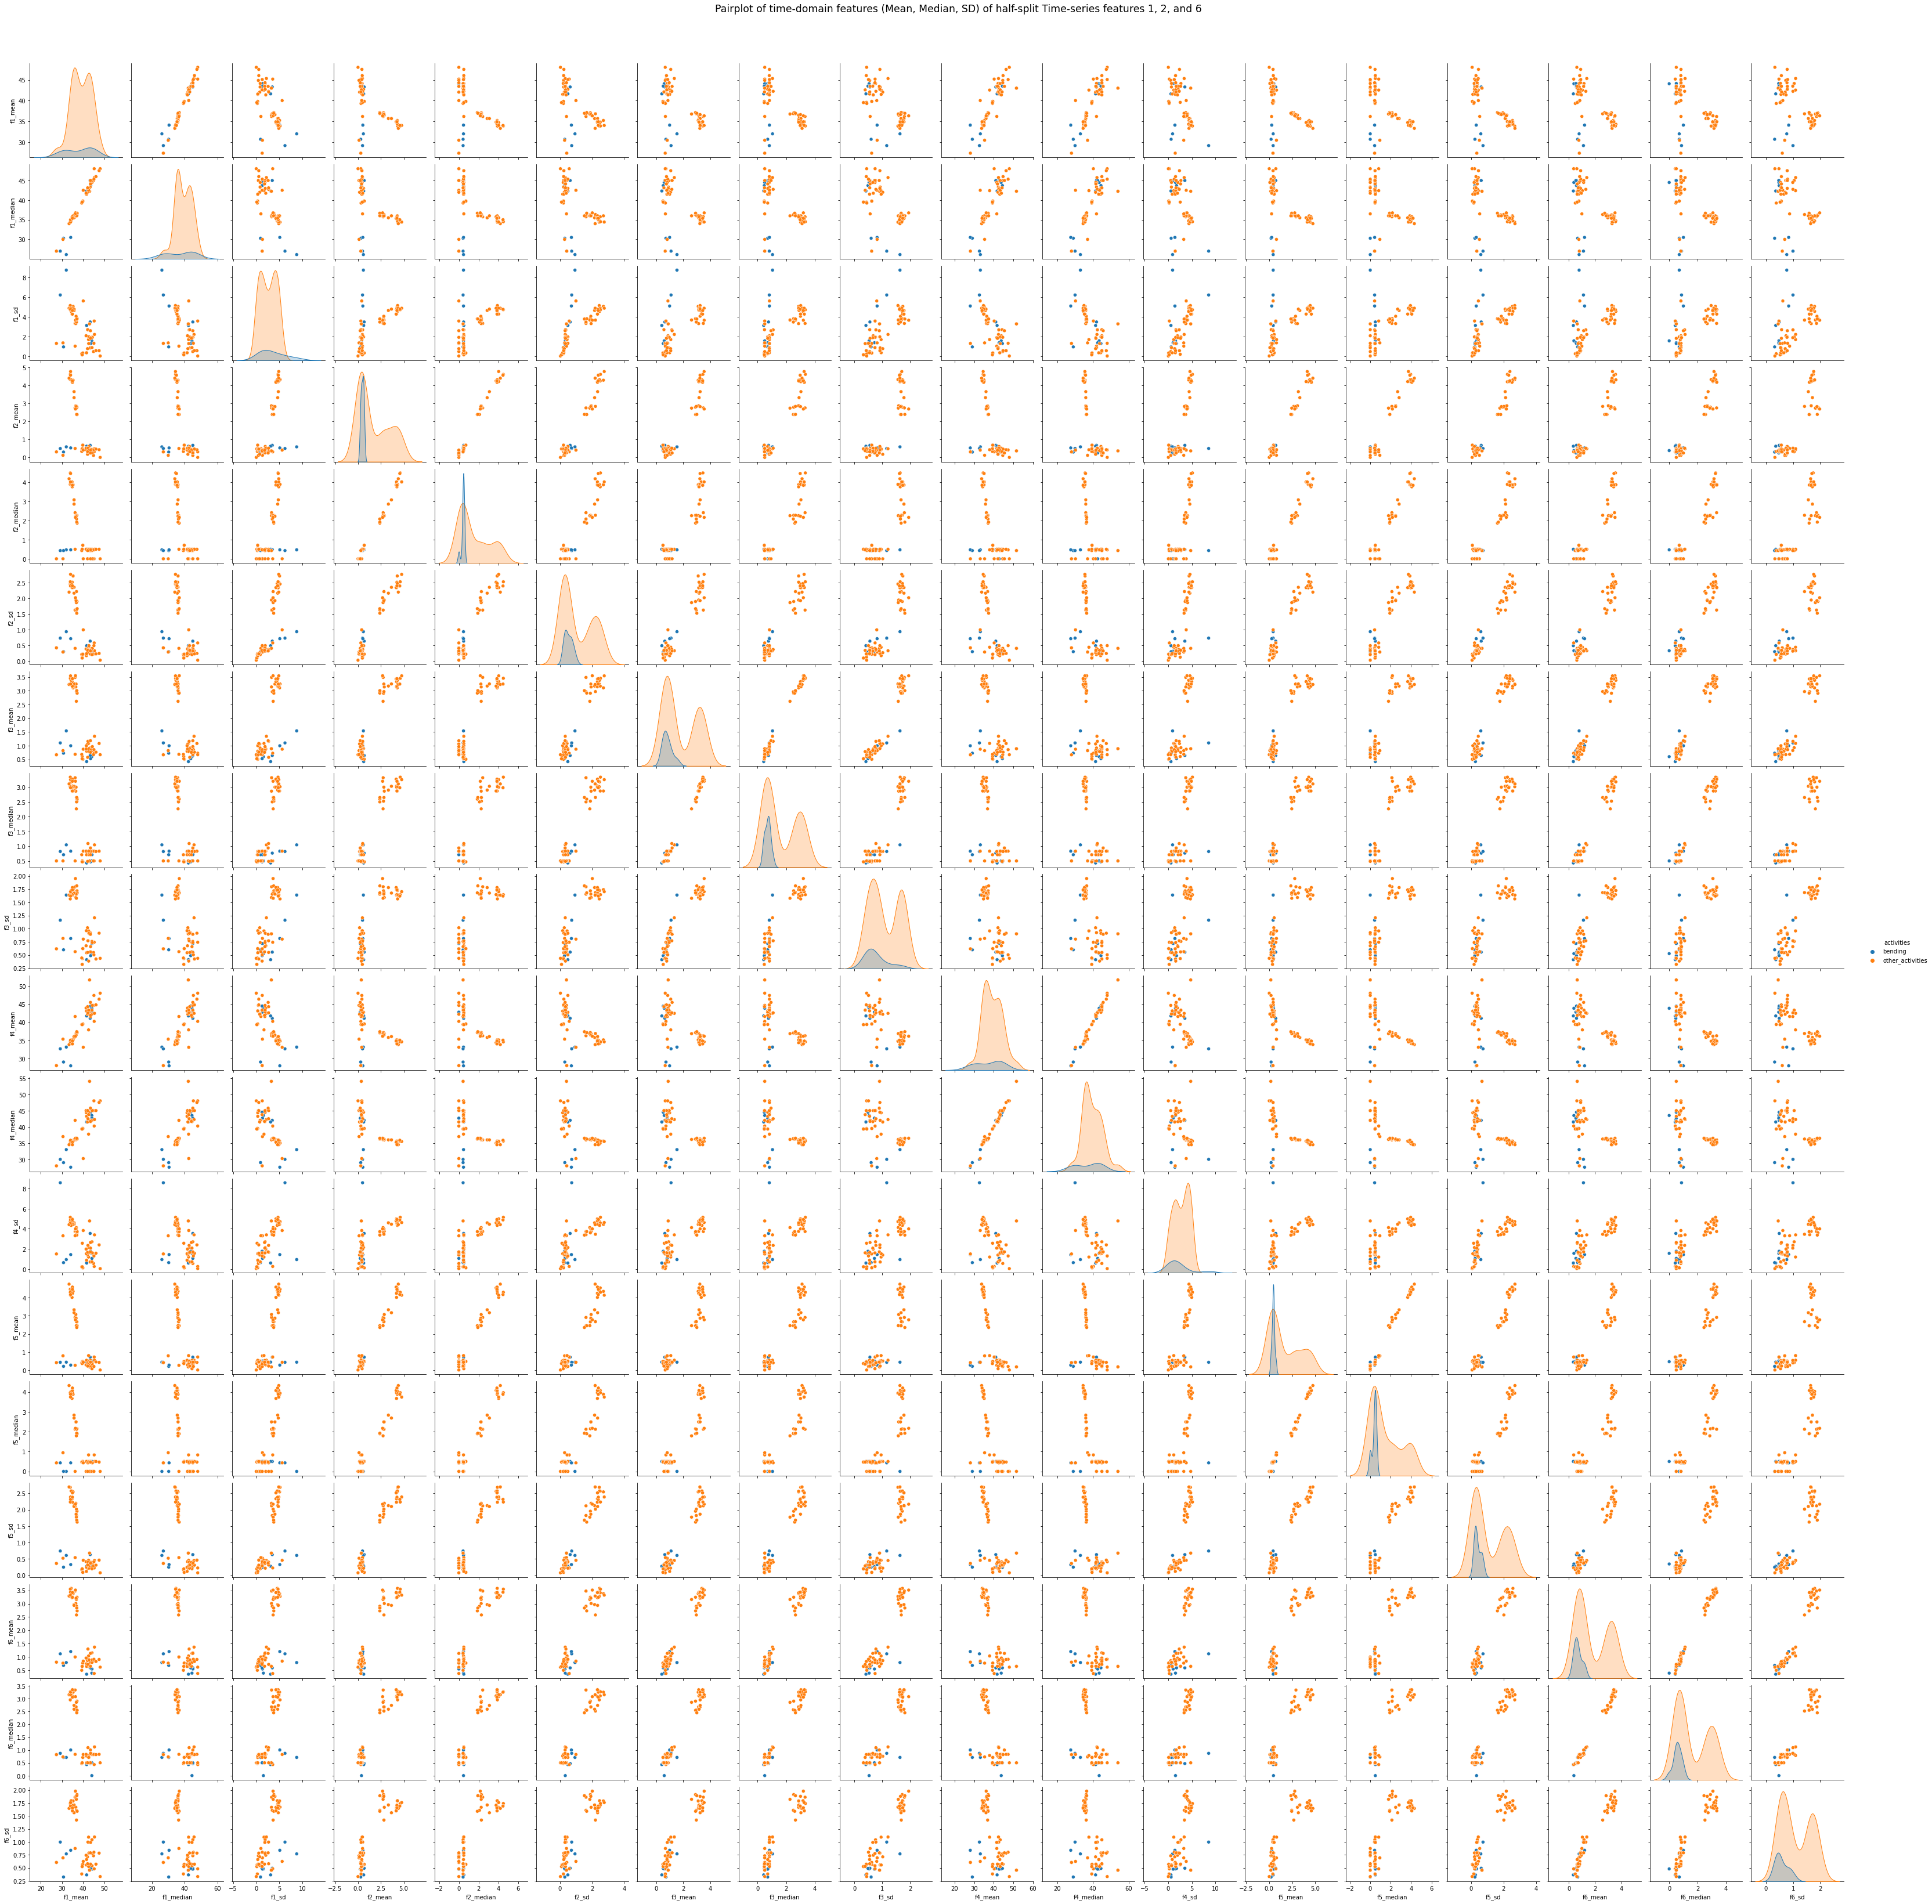

In [8]:
# scatter plot of selected time-domain features
sns.pairplot(data = df_bending_split_2, hue = 'activities')
plt.suptitle('Pairplot of time-domain features (Mean, Median, SD) of half-split Time-series features 1, 2, and 6', fontsize = 'xx-large', y = 1.02)
plt.show()

> Considerable difference between the pairplots of the original data and the split data is not observed by looking at scatterplot of a pair of the features. The classes of bending and other activities seem to not be linearly separable using only 2 of these extracted features for both split and non-split versions of features.

#### (a)-iii. Break each time series in your training set into l ∈ {1, 2, . . . , 20} time series of approximately equal length and use logistic regression to solve the binary classification problem, using time-domain features. Remember that breaking each of the time series does not change the number of instances. It only changes the number of features for each instance. Calculate the p-values for your logistic regression parameters in each model corresponding to each value of l and refit a logistic regression model using your pruned set of features. Alternatively, you can use backward selection using sklearn.feature selection or glm in R. Use 5-fold cross-validation to determine the best value of the pair (l, p), where p is the number of features used in recursive feature elimination. Explain what the right way and the wrong way are to perform cross-validation in this problem. Obviously, use the right way! Also, you may encounter the problem of class imbalance, which may make some of your folds not having any instances of the rare class. In such a case, you can use stratified cross validation. Research what it means and use it if needed.
#### In the following, you can see an example of applying Python’s Recursive Feature Elimination, which is a backward selection algorithm, to logistic re- gression.

In [9]:
df_main_train_relabel = df_main_train.copy()
df_main_train_relabel.loc[(df_main_train_relabel['activities'].str.startswith('bending')), 'activities'] = 'bending'
df_main_train_relabel.loc[~(df_main_train_relabel['activities'].str.startswith('bending')), 'activities'] = 'other_activities'

df_train_X = df_main_train_relabel[['dataset_number', 'df']]
df_train_y = df_main_train_relabel['activities']


In [10]:
# define initial params for 5-fold CV
num_splits = np.arange(1, 21, 1)
result_df_5cv = pd.DataFrame(columns = ['iter_cv', 'num_split', 'num_p', 'training_acc', 'cv_acc'])
skf = StratifiedKFold(n_splits = 5)
num_iter_cv = 0
num_iter_total = 0

# use stratified 5-fold CV to train LogReg to find best (l, p) pair
for train_index, cv_index in skf.split(df_train_X, df_train_y):
    df_train = df_main_train_relabel.loc[train_index, :]
    df_cv = df_main_train_relabel.loc[cv_index, :]
    num_iter_cv += 1
    
    # iterate different number of splits 'l' from 1 to 20 splits
    for s in num_splits:
        df_train_split = gen_time_domain_features(df_train, operation_list = ['mean', 'median', 'sd'], split = s)
        df_cv_split = gen_time_domain_features(df_cv, operation_list = ['mean', 'median', 'sd'], split = s)
        df_train_split_X = df_train_split.loc[:, df_train_split.columns != 'activities']
        df_train_split_y = df_train_split.loc[:, 'activities']
        df_cv_split_X = df_cv_split.loc[:, df_cv_split.columns != 'activities']
        df_cv_split_y = df_cv_split.loc[:, 'activities']
        
        # use RFE to find the ranking of the features
        cls = LogisticRegression(penalty = 'none', random_state = 1) # set penalty = none to remove l2 regularization
        selector = RFE(cls, n_features_to_select = 1, step = 1) # use only n_features = 1 to get full list of ranked p
        selector = selector.fit(df_train_split_X, df_train_split_y)
        ranking = np.array(selector.ranking_)
        
        # for different number of features selected p, train LogReg
        for num_p in range(1, len(df_train_split_X.columns) + 1):
            
            # select features to be used for training LogReg based on RFE's ranking
            df_train_selected_X = df_train_split_X.loc[:, ranking <= num_p]
            df_cv_selected_X = df_cv_split_X.loc[:, ranking <= num_p]
            
            # train LogReg for corresponding (l, p)
            cls = LogisticRegression(penalty = 'none', random_state = 1) # set penalty = none to remove l2 regularization
            cls.fit(df_train_selected_X, df_train_split_y)
            training_acc = cls.score(df_train_selected_X, df_train_split_y)
            cv_acc = cls.score(df_cv_selected_X, df_cv_split_y)
            
            # append results to dataframe
            result_df_5cv.loc[len(result_df_5cv), :] = [num_iter_cv, s, num_p, training_acc, cv_acc]
            
            num_iter_total += 1
            if num_iter_total % 1000 == 0:
                print(num_iter_total)
            

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000


In [11]:
result_df_5cv = result_df_5cv.astype(float)

# average errors on 5-fold CV
grouped_result_5cv = result_df_5cv.groupby(['num_split', 'num_p'])['training_acc', 'cv_acc'].mean()
print(grouped_result_5cv.sort_values(['cv_acc', 'num_p'], ascending = [False, True])[:10])

                 training_acc    cv_acc
num_split num_p                        
9.0       7.0             1.0  0.985714
          8.0             1.0  0.985714
          9.0             1.0  0.985714
          12.0            1.0  0.985714
          13.0            1.0  0.985714
          14.0            1.0  0.985714
          17.0            1.0  0.985714
15.0      34.0            1.0  0.985714
18.0      49.0            1.0  0.985714
12.0      53.0            1.0  0.985714


<ipython-input-11-5f7da9459e09>:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  grouped_result_5cv = result_df_5cv.groupby(['num_split', 'num_p'])['training_acc', 'cv_acc'].mean()


> Since there are many (l, p) combinations that give the highest CV accuracy at 98.57%, the combination with the lowest p will be chosen to minimize overfitting problem: <b> number of splits (l) = 9 and number of features selected (p) = 7 </b>

> <b> Right and wrong way of CV method in this problem </b>
> - Right way is to include CV into the step of feature selection, meaning that we split train/CV into 5 folds and we perform feature selection on each of the 5 train/cv sets separately. Therefore, each time of CV could result in different sets of features selected
> - Wrong way is to firstly perform feature selection and perform cross validation afterwards. This could be biased since the CV set split afterwards has already seen the training data

#### (a)-iv. Report the confusion matrix and show the ROC and AUC for your classifier on train data. Report the parameters of your logistic regression βi’s as well as the p-values associated with them.

In [12]:
# best LogReg classifier with 9 splits (l) and use 7 selected features (p)

df_train_best = gen_time_domain_features(df_main_train, operation_list = ['mean', 'median', 'sd'], split = 9)
df_train_best.loc[(df_train_best['activities'].str.startswith('bending')), 'activities'] = 'bending'
df_train_best.loc[~(df_train_best['activities'].str.startswith('bending')), 'activities'] = 'other_activities'

df_train_best_X = df_train_best.loc[:, df_train_best.columns != 'activities'].astype(float)
df_train_best_y = df_train_best.loc[:, 'activities']
df_train_best_y = df_train_best_y.map({'bending' : 1, 'other_activities' : 0})

cls_temp = LogisticRegression(penalty = 'none', random_state = 1)
selector_best = RFE(cls_temp, n_features_to_select = 1, step = 1)
selector_best = selector_best.fit(df_train_best_X, df_train_best_y)
ranking_best = np.array(selector_best.ranking_)

df_train_best_X = df_train_best_X.loc[:, ranking_best <= 7]


In [13]:
cls_best = LogisticRegression(penalty = 'none', random_state = 1) # set penalty = none to remove l2 regularization
cls_best.fit(df_train_best_X, df_train_best_y)

LogisticRegression(penalty='none', random_state=1)

In [14]:
# confusion matrix
cm = confusion_matrix(df_train_best_y, cls_best.predict(df_train_best_X))
print('Confusion matrix:\n', cm)


Confusion matrix:
 [[60  0]
 [ 0  9]]


Training ROC Curve for the best (l = 9, p = 7) pair Logistic Regression
Training ROC AUC score: 1.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


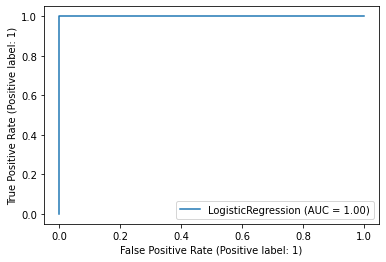

In [15]:
# ROC and AUC
print('Training ROC Curve for the best (l = 9, p = 7) pair Logistic Regression')
plot_roc_curve(cls_best, df_train_best_X, df_train_best_y)

print('Training ROC AUC score:', roc_auc_score(df_train_best_y, cls_best.predict_proba(df_train_best_X)[:, 1]))

In [16]:
# parameters of LogReg and p-values using Statsmodels.api.Logit

df_train_best_X_sm = sm.add_constant(df_train_best_X)

cls_best_sm = sm.Logit(df_train_best_y, df_train_best_X_sm).fit(method = 'lbfgs', maxiter = 5000)

In [17]:
print(cls_best_sm.summary())

                           Logit Regression Results                           
Dep. Variable:             activities   No. Observations:                   69
Model:                          Logit   Df Residuals:                       61
Method:                           MLE   Df Model:                            7
Date:                Fri, 04 Mar 2022   Pseudo R-squ.:                   1.000
Time:                        18:40:40   Log-Likelihood:            -0.00010105
converged:                       True   LL-Null:                       -26.718
Covariance Type:            nonrobust   LLR p-value:                 3.042e-09
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.4959   5.19e+07  -9.55e-09      1.000   -1.02e+08    1.02e+08
f11_mean       3.5123   2.39e+07   1.47e-07      1.000   -4.69e+07    4.69e+07
f11_median     4.7139   1.19e+07   3.97e-07      1.0

> - The coefficients of the best (l, p) = (9, 7) LogReg model is shown above where the first 4 features are positive and the last 3 are negative
> - Since the complete separation is encountered, the p-values for all features are shown to be 1 which is caused by the instability of the algorithm. Moreover, the std err is also very high due to the instability which also causes the CI to not be reliable. However, the coefficients obtained should be reliable since the error is low
> - Note: feature name meaning - e.g. f11 means the 2nd split of the 5th time-series feature, f37 means the 7th split of the 1st time-series feature.

#### (a)-v. Test the classifier on the test set. Remember to break the time series in your test set into the same number of time series into which you broke your training set. Remember that the classifier has to be tested using the features extracted from the test set. Compare the accuracy on the test set with the cross-validation accuracy you obtained previously.

In [18]:
# process test set data
df_test_best = gen_time_domain_features(df_main_test, operation_list = ['mean', 'median', 'sd'], split = 9)
df_test_best.loc[(df_test_best['activities'].str.startswith('bending')), 'activities'] = 'bending'
df_test_best.loc[~(df_test_best['activities'].str.startswith('bending')), 'activities'] = 'other_activities'

df_test_best_X = df_test_best.loc[:, df_test_best.columns != 'activities'].astype(float)
df_test_best_y = df_test_best.loc[:, 'activities']
df_test_best_y = df_test_best_y.map({'bending' : 1, 'other_activities' : 0})

df_test_best_X = df_test_best_X.loc[:, ranking_best <= 7]


In [19]:
# testing accuracy
print('Testing accuracy =', round(cls_best.score(df_test_best_X, df_test_best_y), 4))

Testing accuracy = 0.9474


> Testing accuracy at 94.74% is lower than 5-fold CV accuracy at 98.57%

In [20]:
# test set confusion matrix
cm_test = confusion_matrix(df_test_best_y, cls_best.predict(df_test_best_X))
print('Confusion matrix of test set:\n', cm_test)

Confusion matrix of test set:
 [[14  1]
 [ 0  4]]


#### (a)-vi. Do your classes seem to be well-separated to cause instability in calculating logistic regression parameters?

> Yes, the warning of complete separation has been raised when training LogReg using statsmodels.api.Logit. However, when doing cross-validation to find the best (l, p) using sklearn's LogReg, there is no warning regarding complete separation (no regularization method used)

#### (a)-vii. From the confusion matrices you obtained, do you see imbalanced classes? If yes, build a logistic regression model based on case-control sampling and adjust its parameters. Report the confusion matrix, ROC, and AUC of the model.

> Yes, the imbalanced class is observed as the ratio between the positive label (bending) and negative labels (other activities) is approximately 1:6 (~ 15%). (Using rule of thumb: percentage <20%)

In [21]:
# Train LogReg to find best (l, p) using case-control subsampling method

# define initial params for 5-fold CV
num_splits = np.arange(1, 21, 1)
result_df_5cv_ss = pd.DataFrame(columns = ['iter_cv', 'num_split', 'num_p', 'training_acc', 'cv_acc'])
skf = StratifiedKFold(n_splits = 5)
num_iter_cv = 0
num_iter_total = 0

# use stratified 5-fold CV to train LogReg to find best (l, p) pair
for train_index, cv_index in skf.split(df_train_X, df_train_y):
    df_train = df_main_train_relabel.loc[train_index, :]
    df_cv = df_main_train_relabel.loc[cv_index, :]
    num_iter_cv += 1
    
    # iterate different number of splits 'l' from 1 to 20 splits
    for s in num_splits:
        df_train_split = gen_time_domain_features(df_train, operation_list = ['mean', 'median', 'sd'], split = s)
        df_cv_split = gen_time_domain_features(df_cv, operation_list = ['mean', 'median', 'sd'], split = s)
        df_train_split_X = df_train_split.loc[:, df_train_split.columns != 'activities']
        df_train_split_y = df_train_split.loc[:, 'activities']
        df_cv_split_X = df_cv_split.loc[:, df_cv_split.columns != 'activities']
        df_cv_split_y = df_cv_split.loc[:, 'activities']
        
        # subsampling using imblearn's RandomUnderSampler
        rus = RandomUnderSampler(random_state = 1)
        df_train_split_X, df_train_split_y = rus.fit_resample(df_train_split_X, df_train_split_y)
        
        # use RFE to find the ranking of the features
        cls = LogisticRegression(penalty = 'none', random_state = 1) # set penalty = none to remove l2 regularization
        selector = RFE(cls, n_features_to_select = 1, step = 1) # use only n_features = 1 to get full list of ranked p
        selector = selector.fit(df_train_split_X, df_train_split_y)
        ranking = np.array(selector.ranking_)
        
        # for different number of features selected p, train LogReg
        for num_p in range(1, len(df_train_split_X.columns) + 1):
            
            # select features to be used for training LogReg based on RFE's ranking
            df_train_selected_X = df_train_split_X.loc[:, ranking <= num_p]
            df_cv_selected_X = df_cv_split_X.loc[:, ranking <= num_p]
            
            # train LogReg for corresponding (l, p)
            cls = LogisticRegression(penalty = 'none', random_state = 1) # set penalty = none to remove l2 regularization
            cls.fit(df_train_selected_X, df_train_split_y)
            
            training_acc = cls.score(df_train_selected_X, df_train_split_y)
            cv_acc = cls.score(df_cv_selected_X, df_cv_split_y)
            
            # append results to dataframe
            result_df_5cv_ss.loc[len(result_df_5cv_ss), :] = [num_iter_cv, s, num_p, training_acc, cv_acc]
            
            num_iter_total += 1
            if num_iter_total % 1000 == 0:
                print(num_iter_total)
            

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000


In [22]:
result_df_5cv_ss = result_df_5cv_ss.astype(float)

# average errors on 5-fold CV
grouped_result_5cv_ss = result_df_5cv_ss.groupby(['num_split', 'num_p'])['training_acc', 'cv_acc'].mean()
print(grouped_result_5cv_ss.sort_values(['cv_acc', 'num_p'], ascending = [False, True])[:10])

                 training_acc    cv_acc
num_split num_p                        
9.0       7.0             1.0  0.971429
13.0      12.0            1.0  0.971429
12.0      14.0            1.0  0.971429
          17.0            1.0  0.971429
20.0      18.0            1.0  0.971429
18.0      4.0             1.0  0.957143
3.0       5.0             1.0  0.957143
5.0       5.0             1.0  0.957143
3.0       6.0             1.0  0.957143
5.0       6.0             1.0  0.957143


<ipython-input-22-ca199acd0b79>:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  grouped_result_5cv_ss = result_df_5cv_ss.groupby(['num_split', 'num_p'])['training_acc', 'cv_acc'].mean()


> Similarly to LogReg without performing subsampling, the best (l, p) combination is (9 splits, 7 features). However, the CV accuracy is slightly lower (97.14%) compared to using the whole dataset

In [23]:
# best LogReg classifier - subsampling

# select train set based on best split
df_train_best_ss = gen_time_domain_features(df_main_train, operation_list = ['mean', 'median', 'sd'], split = 9)
df_train_best_ss.loc[(df_train_best_ss['activities'].str.startswith('bending')), 'activities'] = 'bending'
df_train_best_ss.loc[~(df_train_best_ss['activities'].str.startswith('bending')), 'activities'] = 'other_activities'

df_train_best_ss_X = df_train_best_ss.loc[:, df_train_best_ss.columns != 'activities'].astype(float)
df_train_best_ss_y = df_train_best_ss.loc[:, 'activities']
df_train_best_ss_y = df_train_best_ss_y.map({'bending' : 1, 'other_activities' : 0})

# subsampling
rus = RandomUnderSampler(random_state = 1)
df_train_best_ss_X, df_train_best_ss_y = rus.fit_resample(df_train_best_ss_X, df_train_best_ss_y)

# select p features
cls_temp = LogisticRegression(penalty = 'none', random_state = 1)
selector_best_ss = RFE(cls_temp, n_features_to_select = 7, step = 1)
selector_best_ss = selector_best_ss.fit(df_train_best_ss_X, df_train_best_ss_y)
ranking_best_ss = np.array(selector_best_ss.ranking_)

df_train_best_ss_X = df_train_best_ss_X.loc[:, ranking_best_ss <= 7]

# create LogReg classifier
cls_best_ss = LogisticRegression(penalty = 'none', random_state = 1) # set penalty = none to remove l2 regularization
cls_best_ss.fit(df_train_best_ss_X, df_train_best_ss_y)



LogisticRegression(penalty='none', random_state=1)

In [24]:
# correct the estimated intercept of subsampling model
fraction_pos = 13/78
fraction_pos_ss = 0.5
corrected_b0 = cls_best_ss.coef_[0][0] + np.log(fraction_pos/(1 - fraction_pos)) - np.log(fraction_pos_ss/(1 - fraction_pos_ss))
cls_best_ss.coef_[0][0] = corrected_b0

In [25]:
# select test set based on best split
df_test_best_ss = gen_time_domain_features(df_main_test, operation_list = ['mean', 'median', 'sd'], split = 9)
df_test_best_ss.loc[(df_test_best_ss['activities'].str.startswith('bending')), 'activities'] = 'bending'
df_test_best_ss.loc[~(df_test_best_ss['activities'].str.startswith('bending')), 'activities'] = 'other_activities'

df_test_best_ss_X = df_test_best_ss.loc[:, df_test_best_ss.columns != 'activities'].astype(float)
df_test_best_ss_y = df_test_best_ss.loc[:, 'activities']
df_test_best_ss_y = df_test_best_ss_y.map({'bending' : 1, 'other_activities' : 0})

df_test_best_ss_X = df_test_best_ss_X.loc[:, ranking_best_ss <= 7]

In [26]:
# testing accuracy subsampling
print('Testing accuracy (subsampling) =', round(cls_best_ss.score(df_test_best_ss_X, df_test_best_ss_y), 4))

Testing accuracy (subsampling) = 0.9474


> Performing subsampling in order to balance the sample turns out not improve the performance since the testing accuracy is the same at 94.74% compared to not using case-control samplings.

In [27]:
# Confusion matrix case-control
cm_ss = confusion_matrix(df_test_best_ss_y, cls_best_ss.predict(df_test_best_ss_X))
print('Confusion matrix:\n', cm_ss)


Confusion matrix:
 [[15  0]
 [ 1  3]]


Training ROC Curve for the best (l = 9, p = 7) pair Logistic Regression - Subsampling
Training ROC AUC score - Subsampling: 1.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


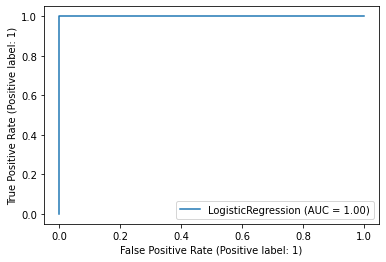

In [28]:
# ROC and AUC case-control
print('Training ROC Curve for the best (l = 9, p = 7) pair Logistic Regression - Subsampling')
plot_roc_curve(cls_best_ss, df_train_best_ss_X, df_train_best_ss_y)

print('Training ROC AUC score - Subsampling:', roc_auc_score(df_train_best_ss_y, cls_best_ss.predict_proba(df_train_best_ss_X)[:, 1]))


## (b) Binary Classification Using L1-penalized logistic regression 

#### (b)-i. Repeat 2(a)iii using L1-penalized logistic regression,8 i.e. instead of using p- values for variable selection, use L1 regularization. Note that in this problem, you have to cross-validate for both l, the number of time series into which you break each of your instances, and λ, the weight of L1 penalty in your logistic regression objective function (or C, the budget). Packages usually perform cross-validation for λ automatically.

In [29]:
list_l = [1, 2, 4, 8, 12, 20]
list_c = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]

In [30]:
df_main_train_relabel = df_main_train.copy()
df_main_train_relabel.loc[(df_main_train_relabel['activities'].str.startswith('bending')), 'activities'] = 'bending'
df_main_train_relabel.loc[~(df_main_train_relabel['activities'].str.startswith('bending')), 'activities'] = 'other_activities'

df_train_X = df_main_train_relabel[['dataset_number', 'df']]
df_train_y = df_main_train_relabel['activities']


In [31]:
# define initial params for 5-fold CV
result_df_5cv_l1 = pd.DataFrame(columns = ['iter_cv', 'num_split', 'c_val', 'training_acc', 'cv_acc'])
skf = StratifiedKFold(n_splits = 5)
num_iter_cv = 0
num_iter_total = 0

# use stratified 5-fold CV to train LogReg to find best (l, C) pair
for train_index, cv_index in skf.split(df_train_X, df_train_y):
    df_train = df_main_train_relabel.loc[train_index, :]
    df_cv = df_main_train_relabel.loc[cv_index, :]
    num_iter_cv += 1
    
    # iterate different number of splits 'l' from 1 to 20 splits
    for s in list_l:
        df_train_split = gen_time_domain_features(df_train, operation_list = ['mean', 'median', 'sd'], split = s)
        df_cv_split = gen_time_domain_features(df_cv, operation_list = ['mean', 'median', 'sd'], split = s)
        df_train_split_X = df_train_split.loc[:, df_train_split.columns != 'activities']
        df_train_split_y = df_train_split.loc[:, 'activities']
        df_cv_split_X = df_cv_split.loc[:, df_cv_split.columns != 'activities']
        df_cv_split_y = df_cv_split.loc[:, 'activities']
        
        # normalize features using StandardScaler
        scaler = StandardScaler()
        df_train_split_X = pd.DataFrame(scaler.fit_transform(df_train_split_X), 
                                           columns = df_train_split_X.columns, index = df_train_split_X.index)
        df_cv_split_X = pd.DataFrame(scaler.transform(df_cv_split_X), 
                                           columns = df_cv_split_X.columns, index = df_cv_split_X.index)
        
        # for different C (regularization coef, budget) params, train LogReg
        for c in list_c:
            
            # train LogReg for corresponding (l, C)
            cls = LogisticRegression(penalty = 'l1', random_state = 1, C = c, solver = 'liblinear', tol = 1e-6, max_iter = int(1e6), warm_start = True)
            cls.fit(df_train_split_X, df_train_split_y)
            training_acc = cls.score(df_train_split_X, df_train_split_y)
            cv_acc = cls.score(df_cv_split_X, df_cv_split_y)
            
            # append results to dataframe
            result_df_5cv_l1.loc[len(result_df_5cv_l1), :] = [num_iter_cv, s, c, training_acc, cv_acc]
            
            num_iter_total += 1
            if num_iter_total % 50 == 0:
                print(num_iter_total)
            

50
100
150
200
250


In [32]:
result_df_5cv_l1 = result_df_5cv_l1.astype(float)
grouped_result_5cv_l1 = result_df_5cv_l1.groupby(['num_split', 'c_val'])['training_acc', 'cv_acc'].mean()
print(grouped_result_5cv_l1.sort_values(['cv_acc', 'c_val'], ascending = [False, True])[:10])

                   training_acc    cv_acc
num_split c_val                          
4.0       1.0               1.0  0.971429
20.0      1.0               1.0  0.971429
          10.0              1.0  0.971429
          100.0             1.0  0.971429
          1000.0            1.0  0.971429
12.0      1.0               1.0  0.957143
4.0       10.0              1.0  0.957143
20.0      10000.0           1.0  0.957143
2.0       10.0              1.0  0.942857
12.0      10.0              1.0  0.942857


<ipython-input-32-959a103f337f>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  grouped_result_5cv_l1 = result_df_5cv_l1.groupby(['num_split', 'c_val'])['training_acc', 'cv_acc'].mean()


> Number of split (l) = 4 and C value = 10 (lambda = 0.1) gives the highest CV accuracy at 97.14%.

In [33]:
# test accuracy

# training and testing set with split = 4
df_train_best_l1 = gen_time_domain_features(df_main_train_relabel, operation_list = ['mean', 'median', 'sd'], split = 4)
df_train_best_l1_X = df_train_best_l1.loc[:, df_train_best_l1.columns != 'activities']
df_train_best_l1_y = df_train_best_l1.loc[:, 'activities']

df_test_best_l1 = gen_time_domain_features(df_main_test, operation_list = ['mean', 'median', 'sd'], split = 4)
df_test_best_l1.loc[(df_test_best_l1['activities'].str.startswith('bending')), 'activities'] = 'bending'
df_test_best_l1.loc[~(df_test_best_l1['activities'].str.startswith('bending')), 'activities'] = 'other_activities'

df_test_best_l1_X = df_test_best_l1.loc[:, df_test_best_l1.columns != 'activities'].astype(float)
df_test_best_l1_y = df_test_best_l1.loc[:, 'activities']

# normalize
scaler = StandardScaler()
df_train_best_l1_X = pd.DataFrame(scaler.fit_transform(df_train_best_l1_X), 
                                   columns = df_train_best_l1_X.columns, index = df_train_best_l1_X.index)
df_test_best_l1_X = pd.DataFrame(scaler.transform(df_test_best_l1_X), 
                                   columns = df_test_best_l1_X.columns, index = df_test_best_l1_X.index)

# best L1-penalized LogReg model when split = 4, C = 10
cls_best_l1 = LogisticRegression(penalty = 'l1', random_state = 1, C = 10, solver = 'liblinear', tol = 1e-6, max_iter = int(1e6), warm_start = True)
cls_best_l1.fit(df_train_best_l1_X, df_train_best_l1_y)


LogisticRegression(C=10, max_iter=1000000, penalty='l1', random_state=1,
                   solver='liblinear', tol=1e-06, warm_start=True)

In [34]:
# test accuracy of LogReg with (l, C) = (4, 10) - L1-penalized
print('Testing Accuracy =', round(cls_best_l1.score(df_test_best_l1_X, df_test_best_l1_y), 4))

Testing Accuracy = 0.9474


#### (b)-ii. Compare the L1-penalized with variable selection using p-values. Which one performs better? Which one is easier to implement?

> - Using variable selection's RFE method (in part a) slightly gives better CV accuracy at 98.57% while L1-penalized method (with Min-Max normalization) gives CV accuracy at 97.14%. 
> - Both methods give the same test accuracy at 94.74%
> - L1-penalized method is easier to implement and less computationally time-consuming given that we didn't have to iterate through numbers of features to select to find the best performance ones.

## (c) Multi-class Classification (The Realistic Case)

#### (c)-i. Find the best l in the same way as you found it in 2(b)i to build an L1- penalized multinomial regression model to classify all activities in your training set. Report your test error. Research how confusion matrices and ROC curves are defined for multiclass classification and show them for this problem if possible.

In [35]:
list_l = [1, 2, 4, 8, 12, 20]
list_c = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]

In [36]:
# group bending1 and bending2 only for multinomial problem
df_main_train_relabel = df_main_train.copy()
df_main_train_relabel.loc[(df_main_train_relabel['activities'].str.startswith('bending')), 'activities'] = 'bending'

df_train_X = df_main_train_relabel[['dataset_number', 'df']]
df_train_y = df_main_train_relabel['activities']


In [37]:
# define initial params for 5-fold CV
result_df_5cv_l1_multi = pd.DataFrame(columns = ['iter_cv', 'num_split', 'c_val', 'training_acc', 'cv_acc'])
skf = StratifiedKFold(n_splits = 5)
num_iter_cv = 0
num_iter_total = 0

# use stratified 5-fold CV to train LogReg to find best (l, C) pair
for train_index, cv_index in skf.split(df_train_X, df_train_y):
    df_train = df_main_train_relabel.loc[train_index, :]
    df_cv = df_main_train_relabel.loc[cv_index, :]
    num_iter_cv += 1
    
    # iterate different number of splits 'l' from 1 to 20 splits
    for s in list_l:
        df_train_split = gen_time_domain_features(df_train, operation_list = ['mean', 'median', 'sd'], split = s)
        df_cv_split = gen_time_domain_features(df_cv, operation_list = ['mean', 'median', 'sd'], split = s)
        df_train_split_X = df_train_split.loc[:, df_train_split.columns != 'activities']
        df_train_split_y = df_train_split.loc[:, 'activities']
        df_cv_split_X = df_cv_split.loc[:, df_cv_split.columns != 'activities']
        df_cv_split_y = df_cv_split.loc[:, 'activities']

        # normalize features using StandardScaler
        scaler = StandardScaler()
        df_train_split_X = pd.DataFrame(scaler.fit_transform(df_train_split_X), 
                                           columns = df_train_split_X.columns, index = df_train_split_X.index)
        df_cv_split_X = pd.DataFrame(scaler.transform(df_cv_split_X), 
                                           columns = df_cv_split_X.columns, index = df_cv_split_X.index)        
        
        # for different C (regularization coef, budget) params, train LogReg
        for c in list_c:
            
            # train LogReg for corresponding (l, C)
            cls = LogisticRegression(penalty = 'l1', random_state = 1, C = c, multi_class = 'multinomial', solver = 'saga', max_iter = int(1e6), warm_start = True)
            cls.fit(df_train_split_X, df_train_split_y)
            training_acc = cls.score(df_train_split_X, df_train_split_y)
            cv_acc = cls.score(df_cv_split_X, df_cv_split_y)
            
            # append results to dataframe
            result_df_5cv_l1_multi.loc[len(result_df_5cv_l1_multi), :] = [num_iter_cv, s, c, training_acc, cv_acc]
            
            num_iter_total += 1
            if num_iter_total % 5 == 25:
                print(num_iter_total)
            

In [38]:
result_df_5cv_l1_multi = result_df_5cv_l1_multi.astype(float)
grouped_result_5cv_l1_multi = result_df_5cv_l1_multi.groupby(['num_split', 'c_val'])['training_acc', 'cv_acc'].mean()
print(grouped_result_5cv_l1_multi.sort_values(['cv_acc', 'c_val'], ascending = [False, True])[:10])


                   training_acc    cv_acc
num_split c_val                          
1.0       1.0          0.952857  0.884615
          10.0         0.996364  0.884615
2.0       10.0         1.000000  0.884615
          1.0          0.992727  0.870330
1.0       100.0        1.000000  0.870330
2.0       100.0        1.000000  0.870330
1.0       1000.0       1.000000  0.870330
2.0       1000.0       1.000000  0.870330
1.0       10000.0      1.000000  0.870330
2.0       10000.0      1.000000  0.870330


<ipython-input-38-cde6d93cb0cd>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  grouped_result_5cv_l1_multi = result_df_5cv_l1_multi.groupby(['num_split', 'c_val'])['training_acc', 'cv_acc'].mean()


> For multinomial classification, the best combination of (l, C) is: number of splits = 2, and value of C = 10 (lambda = 0.1). With this combination, the CV accuracy is at 88.46%

In [39]:
# best model from highest CV accuracy of (l, C) combination

# training set with split = 2
df_train_best_multi = gen_time_domain_features(df_main_train_relabel, operation_list = ['mean', 'median', 'sd'], split = 2)
df_train_best_multi_X = df_train_best_multi.loc[:, df_train_best_multi.columns != 'activities']
df_train_best_multi_y = df_train_best_multi.loc[:, 'activities']

# normalize features using StandardScaler
scaler = StandardScaler()
df_train_best_multi_X = pd.DataFrame(scaler.fit_transform(df_train_best_multi_X), 
                                   columns = df_train_best_multi_X.columns, index = df_train_best_multi_X.index)

# LogReg with C = 10
cls_best_multi = LogisticRegression(penalty = 'l1', random_state = 1, C = 10, multi_class = 'multinomial', solver = 'saga', max_iter = int(1e6), warm_start = True)
cls_best_multi.fit(df_train_best_multi_X, df_train_best_multi_y)



LogisticRegression(C=10, max_iter=1000000, multi_class='multinomial',
                   penalty='l1', random_state=1, solver='saga',
                   warm_start=True)

In [40]:
# testing set accuracy

# processing test set
df_test_best_multi = gen_time_domain_features(df_main_test, operation_list = ['mean', 'median', 'sd'], split = 2)
df_test_best_multi.loc[(df_test_best['activities'].str.startswith('bending')), 'activities'] = 'bending'

df_test_best_multi_X = df_test_best_multi.loc[:, df_test_best_multi.columns != 'activities'].astype(float)
df_test_best_multi_y = df_test_best_multi.loc[:, 'activities']

# normalize X
df_test_best_multi_X = pd.DataFrame(scaler.transform(df_test_best_multi_X), 
                                   columns = df_test_best_multi_X.columns, index = df_test_best_multi_X.index)

# calculate acc
print('Testing Accuracy =', round(cls_best_multi.score(df_test_best_multi_X, df_test_best_multi_y), 4))

Testing Accuracy = 0.7895


> Testing Accuracy of LogReg (l, C) = (2, 10) using L1-penalized regularization is 78.95%

In [41]:
# confusion matrices
print('Confusion Matices for activities: bending, cycling, lying, sitting, standing, walking are shown below in respective order \n',
    multilabel_confusion_matrix(df_test_best_multi_y, cls_best_multi.predict(df_test_best_multi_X),
                                 labels = ['bending', 'cycling', 'lying', 'sitting', 'standing', 'walking']))

Confusion Matices for activities: bending, cycling, lying, sitting, standing, walking are shown below in respective order 
 [[[14  1]
  [ 1  3]]

 [[16  0]
  [ 0  3]]

 [[16  0]
  [ 0  3]]

 [[14  2]
  [ 2  1]]

 [[15  1]
  [ 1  2]]

 [[16  0]
  [ 0  3]]]


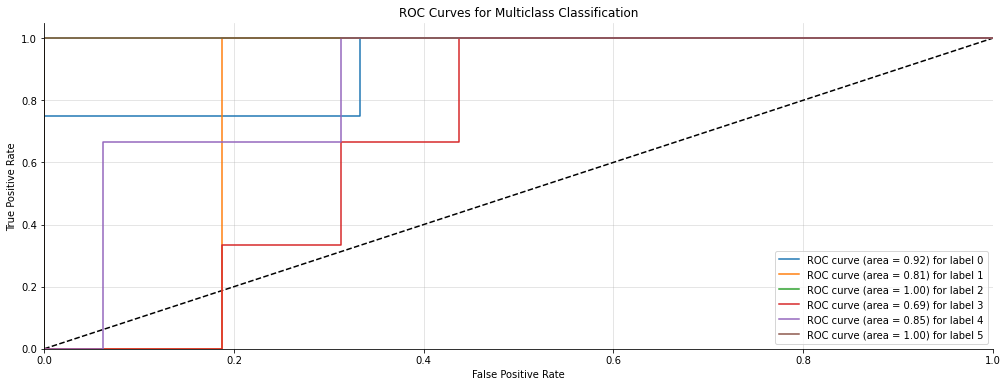

In [42]:
# ROC curves
plot_multiclass_roc(cls_best_multi, df_test_best_multi_X, df_test_best_multi_y, n_classes = 6)

#### (c)-ii. Repeat 2(c)i using a Na ̈ıve Bayes’ classifier. Use both Gaussian and Multi- nomial priors and compare the results.

In [43]:
list_l = [1, 2, 4, 8, 12, 20]

# group bending1 and bending2 only for multinomial problem
df_main_train_relabel = df_main_train.copy()
df_main_train_relabel.loc[(df_main_train_relabel['activities'].str.startswith('bending')), 'activities'] = 'bending'

df_train_X = df_main_train_relabel[['dataset_number', 'df']]
df_train_y = df_main_train_relabel['activities']

In [44]:
# define initial params for 5-fold CV
result_df_5cv_nb = pd.DataFrame(columns = ['iter_cv', 'num_split', 'type_NB', 'training_acc', 'cv_acc'], dtype = float)
skf = StratifiedKFold(n_splits = 5)
num_iter_cv = 0
num_iter_total = 0

# use stratified 5-fold CV to train LogReg to find best split (l)
for train_index, cv_index in skf.split(df_train_X, df_train_y):
    df_train = df_main_train_relabel.loc[train_index, :]
    df_cv = df_main_train_relabel.loc[cv_index, :]
    num_iter_cv += 1
    
    # iterate different number of splits 'l' from 1 to 20 splits
    for s in list_l:
        df_train_split = gen_time_domain_features(df_train, operation_list = ['mean', 'median', 'sd'], split = s)
        df_cv_split = gen_time_domain_features(df_cv, operation_list = ['mean', 'median', 'sd'], split = s)
        df_train_split_X = df_train_split.loc[:, df_train_split.columns != 'activities']
        df_train_split_y = df_train_split.loc[:, 'activities']
        df_cv_split_X = df_cv_split.loc[:, df_cv_split.columns != 'activities']
        df_cv_split_y = df_cv_split.loc[:, 'activities']       
         
        # train Gaussian NB
        cls_g = GaussianNB()
        cls_g.fit(df_train_split_X, df_train_split_y)
        training_acc = cls_g.score(df_train_split_X, df_train_split_y)
        cv_acc = cls_g.score(df_cv_split_X, df_cv_split_y)
        
        # append results to dataframe
        result_df_5cv_nb.loc[len(result_df_5cv_nb), :] = [num_iter_cv, s, 'Gaussian', training_acc, cv_acc]
        
        # train Multinomial NB
        cls_m = MultinomialNB()
        cls_m.fit(df_train_split_X, df_train_split_y)
        training_acc = cls_m.score(df_train_split_X, df_train_split_y)
        cv_acc = cls_m.score(df_cv_split_X, df_cv_split_y)

        # append results to dataframe
        result_df_5cv_nb.loc[len(result_df_5cv_nb), :] = [num_iter_cv, s, 'Multinomial', training_acc, cv_acc]

        num_iter_total += 1
        if num_iter_total % 10 == 0:
            print(num_iter_total)
            

10
20
30


In [45]:
grouped_result_df_5cv_nb = result_df_5cv_nb.groupby(['num_split', 'type_NB'])['training_acc', 'cv_acc'].mean()
print(grouped_result_df_5cv_nb.sort_values('cv_acc', ascending = False)[:20])


                       training_acc    cv_acc
num_split type_NB                            
4.0       Multinomial      0.934675  0.825275
8.0       Multinomial      0.949156  0.825275
20.0      Multinomial      0.952792  0.825275
12.0      Gaussian         0.996429  0.813187
2.0       Multinomial      0.920260  0.810989
12.0      Multinomial      0.949156  0.810989
1.0       Multinomial      0.898442  0.796703
          Gaussian         0.963766  0.781319
2.0       Gaussian         0.985519  0.769231
8.0       Gaussian         0.992792  0.754945
4.0       Gaussian         0.985519  0.753846
20.0      Gaussian         1.000000  0.741758


<ipython-input-45-62a14c66a36e>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  grouped_result_df_5cv_nb = result_df_5cv_nb.groupby(['num_split', 'type_NB'])['training_acc', 'cv_acc'].mean()


> From CV, Gaussian NB performs best when number of splits = 12 with CV accuracy of 81.32% while Multinomial NB performs best when number of splits = 4 with CV accuracy of 82.53%

In [46]:
# best Gaussian NB model

# training set with split = 12
df_train_best_gaussian = gen_time_domain_features(df_main_train_relabel, operation_list = ['mean', 'median', 'sd'], split = 12)
df_train_best_gaussian_X = df_train_best_gaussian.loc[:, df_train_best_gaussian.columns != 'activities']
df_train_best_gaussian_y = df_train_best_gaussian.loc[:, 'activities']

# Gaussian NB model
cls_best_gaussian = GaussianNB()
cls_best_gaussian.fit(df_train_best_gaussian_X, df_train_best_gaussian_y)



GaussianNB()

In [47]:
# best Multinomial NB model

# training set with split = 4
df_train_best_multinomial = gen_time_domain_features(df_main_train_relabel, operation_list = ['mean', 'median', 'sd'], split = 4)
df_train_best_multinomial_X = df_train_best_multinomial.loc[:, df_train_best_multinomial.columns != 'activities']
df_train_best_multinomial_y = df_train_best_multinomial.loc[:, 'activities']

# Gaussian NB model
cls_best_multinomial = MultinomialNB()
cls_best_multinomial.fit(df_train_best_multinomial_X, df_train_best_multinomial_y)



MultinomialNB()

In [48]:
# testing set accuracy

# processing test set for Gaussian NB
df_test_best_gaussian = gen_time_domain_features(df_main_test, operation_list = ['mean', 'median', 'sd'], split = 12)
df_test_best_gaussian.loc[(df_test_best_gaussian['activities'].str.startswith('bending')), 'activities'] = 'bending'

df_test_best_gaussian_X = df_test_best_gaussian.loc[:, df_test_best_gaussian.columns != 'activities'].astype(float)
df_test_best_gaussian_y = df_test_best_gaussian.loc[:, 'activities']

# processing test set for Multinomial NB
df_test_best_multinomial = gen_time_domain_features(df_main_test, operation_list = ['mean', 'median', 'sd'], split = 4)
df_test_best_multinomial.loc[(df_test_best_multinomial['activities'].str.startswith('bending')), 'activities'] = 'bending'

df_test_best_multinomial_X = df_test_best_multinomial.loc[:, df_test_best_multinomial.columns != 'activities'].astype(float)
df_test_best_multinomial_y = df_test_best_multinomial.loc[:, 'activities']

# calculate acc
print('Gaussian NB Testing Accuracy =', round(cls_best_gaussian.score(df_test_best_gaussian_X, df_test_best_gaussian_y), 4))
print('Multinomial NB Testing Accuracy =', round(cls_best_multinomial.score(df_test_best_multinomial_X, df_test_best_multinomial_y), 4))


Gaussian NB Testing Accuracy = 0.8421
Multinomial NB Testing Accuracy = 0.8947


#### (c)-iii. Which method is better for multi-class classification in this problem?

> Multinomial Naive Bayes classifier performs the best for this multi-class classification problem with the test accuracy at 89.47%
> - Multinomial Logistic Regression Test Accuracy = 78.95%
> - Gaussian NB Test Accuracy = 84.21%
> - Multinomial NB Test Accuracy = 89.47%

# ISLR 4.8.3

This problem relates to the QDA model, in which the observations within each class are drawn from a normal distribution with a class-specific mean vector and a class specific covariance matrix. We consider the simple case where p = 1; i.e. there is only one feature.
Suppose that we have K classes, and that if an observation belongs to the kth class then X comes from a one-dimensional normal distribution, X ∼ N(μk,σk2). Recall that the density function for the one-dimensional normal distribution is given in (4.16). Prove that in this case, the Bayes classifier is not linear. Argue that it is in fact quadratic.
Hint: For this problem, you should follow the arguments laid out in Section 4.4.1, but without making the assumption that σ12 = . . . = σK2 .


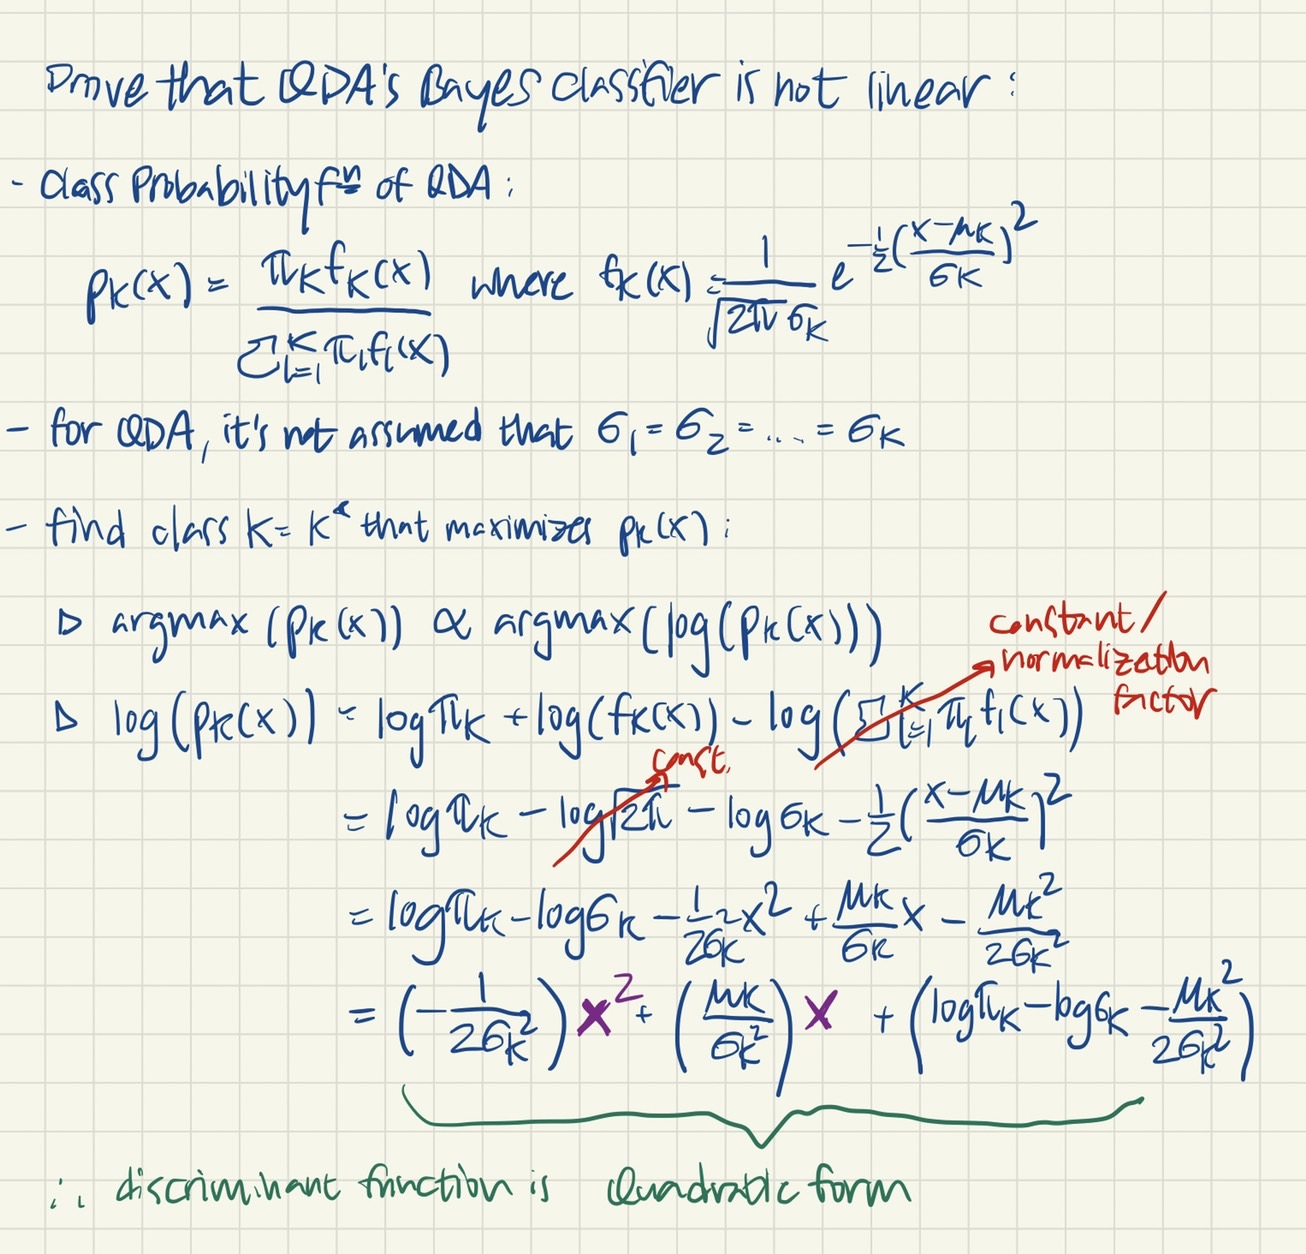

# ISLR 4.8.7

Suppose that we wish to predict whether a given stock will issue a dividend this year (“Yes” or “No”) based on X, last year’s percent profit. We examine a large number of companies and discover that the mean value of X for companies that issued a dividend was X ̄ = 10, while the mean for those that didn’t was X ̄ = 0. In addition, the variance of X for these two sets of companies was σˆ2 = 36. Finally, 80 % of companies issued dividends. Assuming that X follows a nor- mal distribution, predict the probability that a company will issue a dividend this year given that its percentage profit was X = 4 last year.
Hint: Recall that the density function for a normal random variable is f(x) = √ 1 e−(x−μ)2/2σ2 . You will need to use Bayes’ theorem.

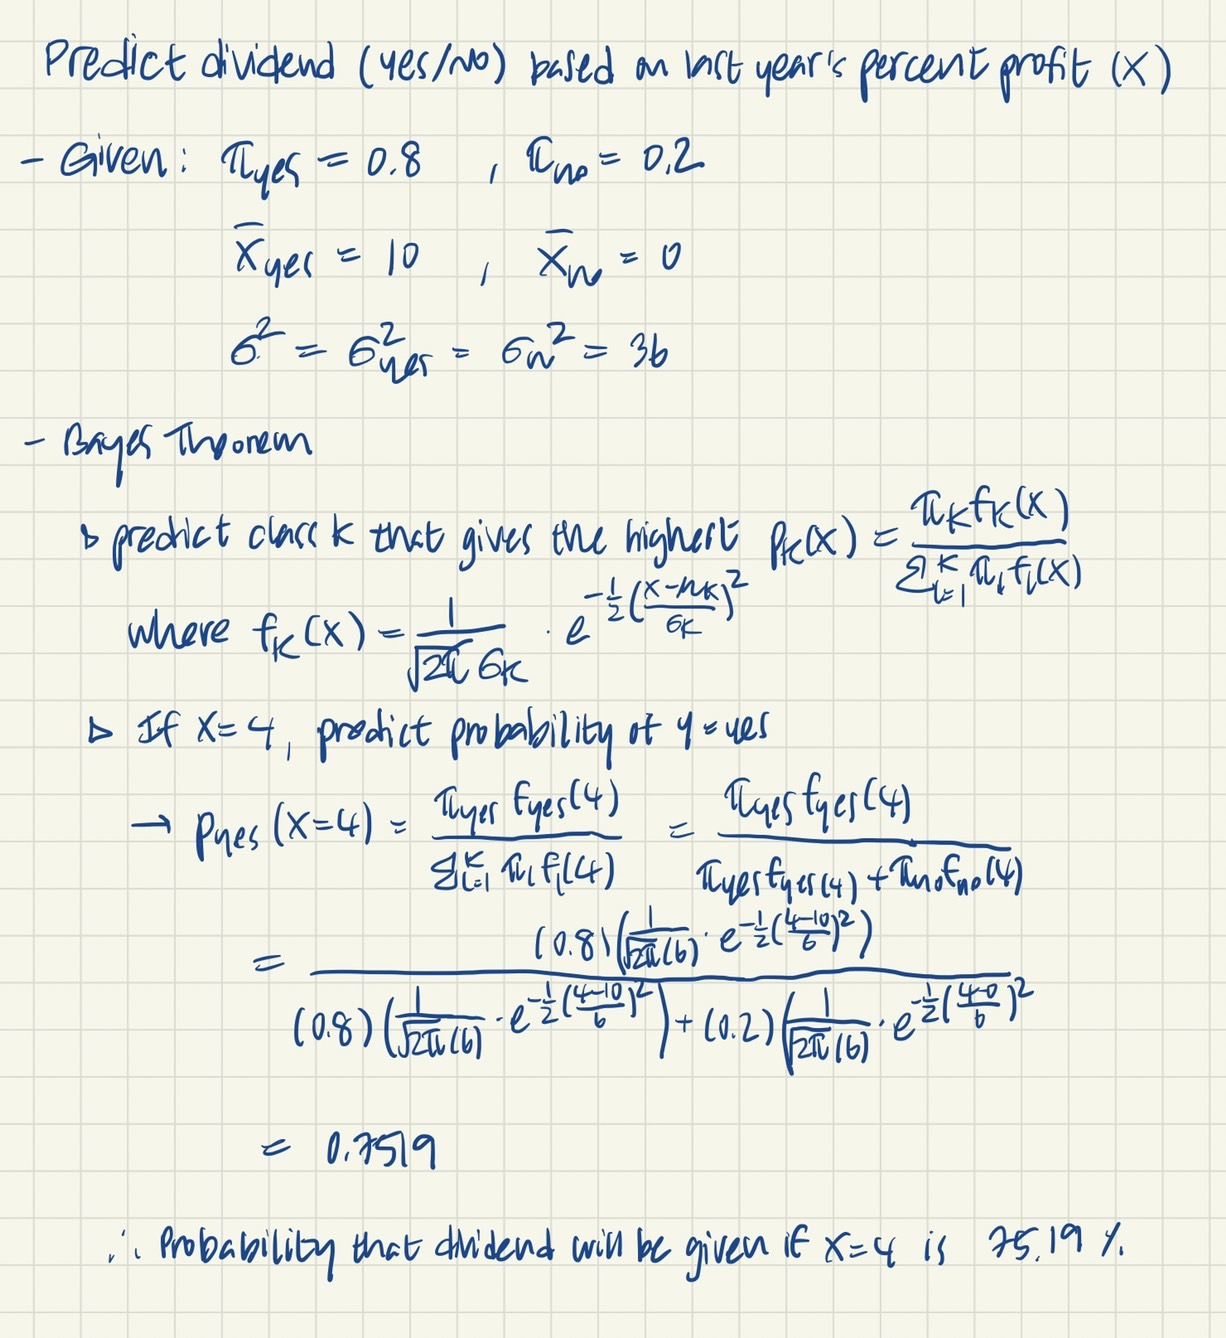